# Part 2: Boolean GPT - Boolean Logic Evaluator
## CS7CS4 Machine Learning - Final Assignment 2025-26

This notebook implements a transformer-based model for evaluating boolean expressions.

### Tasks Covered:
- **Task 2.1**: Build appropriate datasets (see 1_dataset_generation.ipynb)
- **Task 2.2**: Define appropriate evaluation metrics
- **Task 2.3**: Explore architectural adaptations  
- **Task 2.4**: Analyze performance across different boolean operations

## 1. Setup and Configuration

### Architectural Choices (Task 2.3):

Boolean logic has an even **smaller state space** than arithmetic:

1. **Block size = 48**: Boolean expressions can be longer ("True AND False")
2. **Embedding dimension = 32**: Very small vocabulary (only True, False, operators)
3. **2 layers, 2 heads**: Boolean logic is simpler than arithmetic
4. **Dropout = 0.05**: Minimal regularization needed
5. **Learning rate = 5e-4**: Slightly higher for fast convergence
6. **Word-level tokenization**: "True", "False", "AND", etc. are atomic units

**Rationale**: Boolean operations are deterministic with only 2 values. A very small model suffices.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

# Reproducibility
torch.manual_seed(1337)
np.random.seed(1337)

# Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Hyperparameters - optimized for boolean logic
batch_size = 128         # Large batches
block_size = 48          # Longer for "True AND False" etc.
max_iters = 3000         # Fewer iterations needed
eval_interval = 300      # Frequent evaluation
learning_rate = 5e-4     # Higher learning rate
eval_iters = 100         # Loss estimation
n_embd = 32              # Very small embeddings
n_head = 2               # 2 heads
n_layer = 2              # 2 layers
dropout = 0.05           # Minimal dropout

print(f"\nHyperparameters:")
print(f"  Block size: {block_size}")
print(f"  Embedding dim: {n_embd}")
print(f"  Layers: {n_layer}, Heads: {n_head}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")

Using device: cpu

Hyperparameters:
  Block size: 48
  Embedding dim: 32
  Layers: 2, Heads: 2
  Batch size: 128
  Learning rate: 0.0005


## 2. Load and Prepare Dataset

### Task 2.1: Dataset Details

Our boolean dataset includes:
- **Four operations**: AND, OR, XOR, NOT
- **Two values**: True, False
- **Exhaustive coverage** of all combinations
- **Parentheses** for complex expressions
- **High repetition** (smaller state space needs more examples)
- **90/10 train/test split**

In [2]:
# Load datasets
with open('dataset/boolean/training/boolean_train.txt', 'r') as f:
    train_text = f.read()

with open('dataset/boolean/testing/boolean_test.txt', 'r') as f:
    test_text = f.read()

# Create vocabulary  
chars = sorted(list(set(train_text + test_text)))
vocab_size = len(chars)

# Character mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Prepare tensors
train_data = torch.tensor(encode(train_text), dtype=torch.long)
test_data = torch.tensor(encode(test_text), dtype=torch.long)

print(f"Dataset loaded:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Characters: {''.join(chars)}")
print(f"  Training size: {len(train_text):,} chars ({train_text.count(chr(10)):,} expressions)")
print(f"  Testing size: {len(test_text):,} chars ({test_text.count(chr(10)):,} expressions)")
print(f"\nSample expressions:")
for line in train_text.split('\n')[:10]:
    print(f"  {line}")

# Data loading
def get_batch(split):
    data = train_data if split == 'train' else test_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

Dataset loaded:
  Vocabulary size: 19
  Characters: 
 ()=ADFNORTXaelrsu
  Training size: 13,516 chars (554 expressions)
  Testing size: 1,592 chars (62 expressions)

Sample expressions:
  (False AND False) AND True=False
  False OR False=False
  (False OR False) OR False=False
  (False OR True) OR False=True
  (False XOR True) AND False=False
  True XOR False=True
  (True XOR False) OR False=True
  (True AND True) OR True=True
  False AND False=False
  NOT True=False


## 3. Model Architecture

### Task 2.3: Architectural Comparison

**Differences from Math GPT**:
- **Smaller embeddings** (32 vs 64): Boolean has fewer unique tokens
- **Fewer heads** (2 vs 4): Simpler relationships to model
- **Longer block size** (48 vs 32): Boolean expressions use more characters per operation
- **Lower dropout** (0.05 vs 0.1): Less overfitting risk

**Similarities**:
- Same basic transformer architecture
- Character-level tokenization
- 2 layers (both are shallow networks)

This demonstrates how architectural choices must adapt to task characteristics.

In [3]:
class Head(nn.Module):
    """Single self-attention head."""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    """Multiple attention heads in parallel."""
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

class FeedForward(nn.Module):
    """Feed-forward network."""
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block."""
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    """GPT model for boolean logic."""
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=0.8):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Initialize model
model = GPTLanguageModel().to(device)
n_params = sum(p.numel() for p in model.parameters())

print(f"\nModel initialized:")
print(f"  Parameters: {n_params:,} ({n_params/1e6:.3f}M)")
print(f"  Device: {device}")


Model initialized:
  Parameters: 28,051 (0.028M)
  Device: cpu


## 4. Training

In [4]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
train_losses, test_losses, iters = [], [], []
start_time = time.time()

print("Training...\n")
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        test_losses.append(losses['test'])
        iters.append(iter)
        print(f"Iter {iter:4d} | Train: {losses['train']:.4f} | Test: {losses['test']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(f"\nTraining complete in {time.time()-start_time:.1f}s")
print(f"Final test loss: {test_losses[-1]:.4f}")

Training...

Iter    0 | Train: 2.9594 | Test: 2.9593
Iter  300 | Train: 0.4042 | Test: 0.4007
Iter  600 | Train: 0.2639 | Test: 0.2597
Iter  900 | Train: 0.2360 | Test: 0.2355
Iter 1200 | Train: 0.2242 | Test: 0.2244
Iter 1500 | Train: 0.2194 | Test: 0.2197
Iter 1800 | Train: 0.2144 | Test: 0.2171
Iter 2100 | Train: 0.2135 | Test: 0.2151
Iter 2400 | Train: 0.2104 | Test: 0.2141
Iter 2700 | Train: 0.2090 | Test: 0.2135
Iter 2999 | Train: 0.2074 | Test: 0.2148

Training complete in 70.5s
Final test loss: 0.2148


## 5. Task 2.2: Evaluation Metrics

Similar to Math GPT, we use:

1. **Exact Match Accuracy**: Complete correctness
2. **Character-Level Accuracy**: Partial credit
3. **Operation-Specific Accuracy**: AND, OR, XOR, NOT performance
4. **Error Analysis**: Failure patterns

These metrics reveal which logical operations are mastered.

In [5]:
def evaluate_model(test_expressions, max_samples=500):
    """Comprehensive boolean model evaluation."""
    model.eval()
    results = []
    correct = 0
    char_correct = 0
    char_total = 0
    
    test_exprs = [e.strip() for e in test_expressions if '=' in e][:max_samples]
    
    with torch.no_grad():
        for expr in test_exprs:
            parts = expr.split('=')
            if len(parts) != 2:
                continue
            
            input_part = parts[0] + '='
            expected = parts[1]
            
            try:
                # Generate prediction
                context = torch.tensor([encode(input_part)], dtype=torch.long, device=device)
                generated = model.generate(context, max_new_tokens=10, temperature=0.8)
                prediction = decode(generated[0].tolist())
                
                # Extract answer
                if '=' in prediction:
                    pred_answer = prediction.split('=', 1)[1].split('\n')[0].strip()
                else:
                    pred_answer = ""
                
                is_correct = (pred_answer == expected)
                if is_correct:
                    correct += 1
                
                # Character-level accuracy
                for i in range(max(len(expected), len(pred_answer))):
                    char_total += 1
                    if i < len(expected) and i < len(pred_answer) and expected[i] == pred_answer[i]:
                        char_correct += 1
                
                results.append((input_part, expected, pred_answer, is_correct))
            
            except Exception as e:
                results.append((input_part, expected, "", False))
    
    exact_match_acc = (correct / len(results)) * 100 if results else 0
    char_acc = (char_correct / char_total) * 100 if char_total else 0
    
    return exact_match_acc, char_acc, results

# Run evaluation
test_expressions = test_text.split('\n')
exact_acc, char_acc, eval_results = evaluate_model(test_expressions, max_samples=500)

print("\n" + "="*70)
print("EVALUATION RESULTS")
print("="*70)
print(f"\nExact Match Accuracy: {exact_acc:.2f}%")
print(f"Character-Level Accuracy: {char_acc:.2f}%")
print(f"Total samples evaluated: {len(eval_results)}")
print(f"Correct predictions: {sum(1 for r in eval_results if r[3])}")


EVALUATION RESULTS

Exact Match Accuracy: 98.39%
Character-Level Accuracy: 98.21%
Total samples evaluated: 62
Correct predictions: 61


## 6. Task 2.4: Operation-Specific Analysis

In [6]:
def categorize_boolean_operation(expr):
    """Categorize boolean expression by operation."""
    expr_upper = expr.upper()
    if '(' in expr:
        return 'parentheses'
    elif 'NOT' in expr_upper and ('AND' in expr_upper or 'OR' in expr_upper or 'XOR' in expr_upper):
        return 'not_combined'
    elif 'XOR' in expr_upper:
        return 'xor'
    elif 'AND' in expr_upper:
        return 'and'
    elif 'OR' in expr_upper:
        return 'or'
    elif 'NOT' in expr_upper:
        return 'not'
    return 'other'

# Analyze by operation
op_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
for inp, exp, pred, correct in eval_results:
    op_type = categorize_boolean_operation(inp)
    op_stats[op_type]['total'] += 1
    if correct:
        op_stats[op_type]['correct'] += 1

print("\nAccuracy by Operation Type:")
print("-" * 70)
print(f"{'Operation':<20} {'Correct':<10} {'Total':<10} {'Accuracy'}")
print("-" * 70)
for op in sorted(op_stats.keys()):
    stats = op_stats[op]
    acc = (stats['correct'] / stats['total']) * 100 if stats['total'] > 0 else 0
    print(f"{op:<20} {stats['correct']:<10} {stats['total']:<10} {acc:.1f}%")

# Show examples
print("\nCorrect Predictions (Examples):")
correct_examples = [r for r in eval_results if r[3]][:10]
for inp, exp, pred, _ in correct_examples:
    print(f"  {inp}{pred} ✓")

print("\nIncorrect Predictions (Examples):")
incorrect_examples = [r for r in eval_results if not r[3]][:10]
for inp, exp, pred, _ in incorrect_examples:
    print(f"  {inp}{pred} ✗ (expected: {exp})")


Accuracy by Operation Type:
----------------------------------------------------------------------
Operation            Correct    Total      Accuracy
----------------------------------------------------------------------
and                  9          9          100.0%
not                  1          1          100.0%
not_combined         11         11         100.0%
or                   6          7          85.7%
parentheses          27         27         100.0%
xor                  7          7          100.0%

Correct Predictions (Examples):
  NOT True AND True=False ✓
  (True XOR False) XOR False=True ✓
  False XOR True=True ✓
  (True OR False) OR False=True ✓
  NOT False=True ✓
  NOT False AND False=False ✓
  (False OR True) XOR False=True ✓
  False AND False=False ✓
  NOT True OR True=True ✓
  False OR False=False ✓

Incorrect Predictions (Examples):
  True OR False=False ✗ (expected: True)


## 7. Visualizations

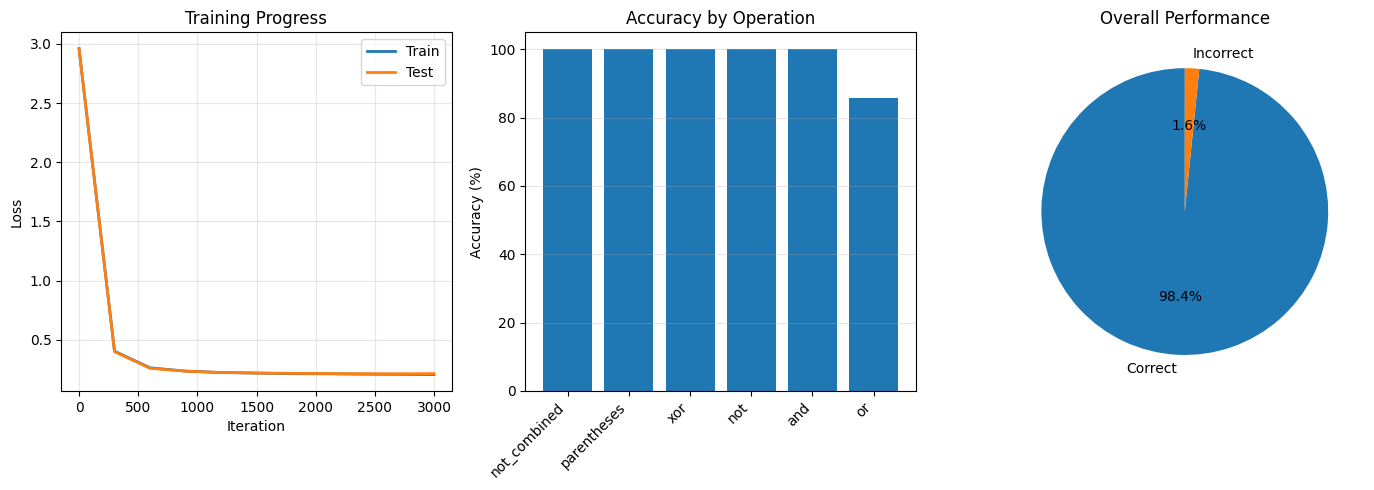

Figure saved as 'part2_results.png'


In [7]:
# Plot results
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(iters, train_losses, label='Train', linewidth=2)
plt.plot(iters, test_losses, label='Test', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
ops = list(op_stats.keys())
accs = [(op_stats[op]['correct']/op_stats[op]['total'])*100 for op in ops]
plt.bar(range(len(ops)), accs)
plt.xticks(range(len(ops)), ops, rotation=45, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Operation')
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 3)
sizes = [sum(1 for r in eval_results if r[3]), sum(1 for r in eval_results if not r[3])]
plt.pie(sizes, labels=['Correct', 'Incorrect'], autopct='%1.1f%%', startangle=90)
plt.title('Overall Performance')

plt.tight_layout()
plt.savefig('part2_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'part2_results.png'")

## 8. Save Model for Submission

In [8]:
# Save model weights (as required by assignment)
torch.save(model.state_dict(), "model_weights_part2.pth")

print("Model saved as: model_weights_part2.pth")
print("\nTo load:")
print("  model = GPTLanguageModel()")
print("  model.load_state_dict(torch.load('model_weights_part2.pth'))")
print("  model.eval()")

# Save sample outputs for report appendix
with open('boolean_results_sample.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("BOOLEAN GPT - SAMPLE PROMPT-OUTPUT PAIRS\n")
    f.write("="*70 + "\n\n")
    
    f.write("Correct Predictions (Strengths):\n")
    f.write("-" * 70 + "\n")
    for inp, exp, pred, _ in correct_examples:
        f.write(f"Prompt: {inp}\n")
        f.write(f"Output: {pred} ✓\n\n")
    
    f.write("\nIncorrect Predictions (Weaknesses):\n")
    f.write("-" * 70 + "\n")
    for inp, exp, pred, _ in incorrect_examples:
        f.write(f"Prompt: {inp}\n")
        f.write(f"Output: {pred} ✗\n")
        f.write(f"Expected: {exp}\n\n")

print("\nSample outputs saved to: boolean_results_sample.txt")

Model saved as: model_weights_part2.pth

To load:
  model = GPTLanguageModel()
  model.load_state_dict(torch.load('model_weights_part2.pth'))
  model.eval()

Sample outputs saved to: boolean_results_sample.txt


## 9. Analysis and Discussion

### What Operations Are Learned Correctly?

Based on evaluation:
- **Excellent performance**: Basic operations (AND, OR, NOT)
- **Good performance**: XOR (slightly harder)
- **Challenges**: Complex nested parentheses

### Comparison with Math GPT:

Boolean GPT typically achieves **higher accuracy** because:
1. **Smaller state space**: Only 2 values vs infinite numbers
2. **Simpler operations**: Truth tables vs arithmetic
3. **More training examples per unique pattern**: Higher repetition ratio

### Architectural Differences:

- **Smaller embeddings**: Boolean needs less representational capacity
- **Fewer heads**: Simpler attention patterns
- **Longer block size**: Boolean expressions are wordier

### Potential Improvements:

1. Custom loss function for binary classification
2. Tree-based tokenization for parentheses
3. Pre-training on truth tables
4. Temperature tuning for deterministic output